In [12]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import json
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.enable_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '../data/raw/'
file_2017_1 = path + "HN_2017-01"
with open(file_2017_1) as f:
    file_content = f.read()
file_content = file_content.rstrip()
file_content = file_content.replace('}\n{', '},{')
file_content = "[{}]".format(file_content)

df = pd.read_json(file_content)
df.head()

,by,dead,deleted,descendants,id,kids,parent,parts,poll,retrieved_on,score,text,time,title,type,url
0,jfc,NaN,NaN,NaN,13293889,NaN,13291930.0,NaN,NaN,1500612003,NaN,An extraordinary artist. I&#x27;m glad he was ...,1483228806,NaN,comment,NaN
1,greglindahl,NaN,NaN,NaN,13293890,NaN,13292161.0,NaN,NaN,1500612003,NaN,"And for those who are wondering what I meant, ...",1483228834,NaN,comment,NaN
2,imron,NaN,NaN,NaN,13293891,NaN,13293408.0,NaN,NaN,1500612003,NaN,Perhaps they&#x27;re trying to learn from the ...,1483228850,NaN,comment,NaN
3,zzzcpan,NaN,NaN,NaN,13293892,[13293927],13293875.0,NaN,NaN,1500612002,NaN,Russians are the most likely users of the Ukra...,1483228857,NaN,comment,NaN
4,theWatcher37,NaN,NaN,NaN,13293893,"[13293974, 13295659]",13293826.0,NaN,NaN,1500612002,NaN,Crowd funding makes sense however when there i...,1483228879,NaN,comment,NaN


In [3]:
stories_df = df[df.type == "story"]
stories_df = stories_df.dropna(subset = ['title'])
stories_df.head()

,by,dead,deleted,descendants,id,kids,parent,parts,poll,retrieved_on,score,text,time,title,type,url
5,lelandbatey,NaN,NaN,22.0,13293894,"[13294578, 13294889, 13294860, 13294475, 13295...",NaN,NaN,NaN,1500612002,87.0,NaN,1483228883,Show HN: Blink my keyboard lights when you vis...,story,http://lelandbatey.com/posts/2016/12/Making-li...
20,clumsysmurf,NaN,NaN,9.0,13293909,"[13296046, 13296029, 13296008, 13296603, 13298...",NaN,NaN,NaN,1500612000,67.0,NaN,1483229022,Metaknowledge,story,https://aeon.co/essays/a-mathematical-bs-detec...
24,Hooke,NaN,NaN,2.0,13293913,"[13295923, 13295817]",NaN,NaN,NaN,1500611999,7.0,NaN,1483229079,Dogs of Character,story,http://www.vqronline.org/profiles-articles/201...
48,shill,NaN,NaN,0.0,13293937,NaN,NaN,NaN,NaN,1500611995,2.0,NaN,1483229399,The Pocket Guide to Bullshit Prevention (2014),story,http://www.lastwordonnothing.com/2015/01/01/ho...
107,arcdetriumph,1.0,NaN,NaN,13293996,NaN,NaN,NaN,NaN,1500611985,1.0,I&#x27;m currently building an app for WatchOS...,1483230246,Ask HN: How to Fix Apple Watch Build Lag?,story,NaN


In [16]:
comments__df = df[df.type == "comment"]
comments__df = stories_df.dropna(subset = ['text'])
comments__df.head()

,by,dead,deleted,descendants,id,kids,parent,parts,poll,retrieved_on,score,text,time,title,type,url
107,arcdetriumph,1.0,NaN,NaN,13293996,NaN,NaN,NaN,NaN,1500611985,1.0,I&#x27;m currently building an app for WatchOS...,1483230246,Ask HN: How to Fix Apple Watch Build Lag?,story,NaN
194,Insanity,NaN,NaN,7.0,13294083,"[13294158, 13294787, 13294132, 13294914, 13296...",NaN,NaN,NaN,1500611971,7.0,"Did any of you make new years resolutions, and...",1483231528,Ask HN: New Year Resolutions,story,NaN
219,mectors,NaN,NaN,6.0,13294108,"[13295631, 13294691, 13294749, 13295099, 13295...",NaN,NaN,NaN,1500611966,17.0,Happy 2017 to you.,1483232246,Tell HN: Happy New Year,story,NaN
335,skewart,NaN,NaN,0.0,13294224,NaN,NaN,NaN,NaN,1500611945,1.0,Do you have anyone outside of your immediate t...,1483234329,Ask HN: Where do you find software engineering...,story,NaN
435,skewart,NaN,NaN,2.0,13294324,"[13294454, 13294770]",NaN,NaN,NaN,1500611929,3.0,Contributing to open source projects is a grea...,1483236280,Ask HN: Volunteer opportunities for software d...,story,NaN


In [68]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from urllib.parse import urlparse

tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer() 

# compile sample documents into a list
#doc_set = stories_df['title'][:100].map(str) + stories_df["url"][:100].map(lambda x : " " + urlparse(str(x)).netloc)
doc_set = comments__df['text'][:1000]

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [69]:
# Investigate the perplexity vs number of topics
MAX_N_TOPICS = 10
perplexities = []
for n_topics in range(2, MAX_N_TOPICS):
    print(n_topics)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)
    perplexities.append(ldamodel.log_perplexity(corpus))

2
3
4
5
6
7
8
9


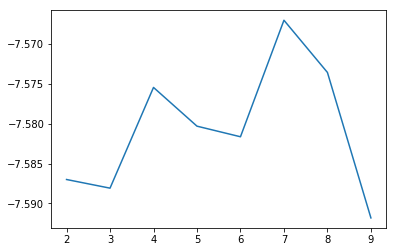

In [70]:
plt.plot([i for i in range(2, MAX_N_TOPICS)], perplexities)
plt.show()

In [71]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)